In [1]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torchnet as tnt
from torchvision.datasets.mnist import MNIST
from torchnet.engine import Engine
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.init import kaiming_normal
from torchvision import models


from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook as tqdm
from torchsummary import summary

print(torch.__version__)
device = torch.device('cuda:0')

#Capsule Model
from Models import*

1.2.0


In [2]:
class Weedread(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('data'), np.uint8)
        self.target_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return self.input_images.shape[0]

    def __getitem__(self, idx):
        images = self.input_images[idx] / 255.0
        classes = self.target_labels[idx]
        if self.transform is not None:
            images = self.transform(images)
        images = images
        
        return images, classes

In [3]:
INPUT_CHANNEL = 3
BATCH_SIZE = 50
normalize = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

imagenet_classes = range(1, 9)

data_path = os.path.dirname(os.getcwd()) + "/data/weed/"
Train_data = Weedread(data_path + "blank_weed128.h5", transform = normalize)
#Test_data = Weedread(data_path + "val.h5")

Train_dataloader = DataLoader(dataset=Train_data, batch_size = BATCH_SIZE, num_workers=8, shuffle=True)
#Test_dataloader = DataLoader(dataset=Test_data, batch_size = BATCH_SIZE, num_workers=8, shuffle=False)
print(Train_data.__len__())
def get_iterator(mode):
    if mode is True:
        return Train_dataloader
    elif mode is False:
        return Test_dataloader

23160


In [4]:
_model = DynamicCaps_MLP(NUM_CLASSES=8, input_channel=3, size=128)
_model.to(device)
summary(_model, input_size=(3, 128, 128))
_loss = LossReconstruct()
optimizer = torch.optim.Adam(_model.parameters(), lr=0.01)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [5]:
def imshow_multi(list_img, title = None, n_cols = 10):
    n_rows = math.ceil((len(list_img))/n_cols)
    fig, axes = plt.subplots(n_rows,n_cols, figsize=(3*n_cols,3*n_rows))
    for i,ax in enumerate(axes.flat):
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i>=(list_img.shape[0]):
            continue
        if(title != None):
            ax.set_title("layer " + str(title[i]))

        img = np.transpose(list_img[i], (1, 2, 0))
        #img = list_img[i][0]
        #ax.imshow(img, cmap='gray')
        ax.imshow(img, cmap='gray')
        
    plt.tight_layout()

In [6]:
NUM_CLASSES=8
def main():
    #main processor
    def h(sample):
        data, o_labels, training = sample
#         if(training):
#             _model.train()
#         else:
#             _model.eval()
            
        labels = torch.LongTensor(o_labels)
        data = data.to(device).float()
        labels = torch.eye(NUM_CLASSES).index_select(dim=0, index=labels).to(device)
        
        classes, reconstructions = _model(data, labels)
        loss = _loss(labels, classes, data, reconstructions)
        return loss, [classes, reconstructions]
    
    #---------log--------------
    def plot_log(log):
        log = np.array(log)
        fig = plt.figure(figsize = (15, 8))
        #loss
        plt.plot(log[:,0]); plt.plot(log[:,2])
        plt.title("Loss per epoch"); plt.xlabel("epochs"); plt.ylabel("error")
        plt.legend(["training loss", "validation loss"])
        plt.show()
        fig = plt.figure(figsize = (15, 8))
        #accuracy
        max_value = np.round(np.max(log[:, 3]), decimals=4)
        max_index = np.argmax(log[:, 3])
        plt.plot(log[:,1]); plt.plot(log[:,3])
        plt.text(max_index, max_value + 0.2, str(max_value), fontsize=10)
        plt.title("Accuracy per epoch"); plt.xlabel("epochs"); plt.ylabel("ACC")
        plt.legend(["training accuracy", "validation accuracy"])
        plt.show()
        
    log = []
    engine = Engine()
    EPOCHS = 50
    meter_loss = tnt.meter.AverageValueMeter()
    classerr = tnt.meter.ClassErrorMeter(accuracy=True)
    
    def reset_meters():
        classerr.reset()
        meter_loss.reset()

    def on_sample(state):
        state['sample'].append(state['train'])

    def on_forward(state):
        classerr.add(state['output'][0].data, torch.LongTensor(state['sample'][1]))
        meter_loss.add(state['loss'].item())

    def on_start_epoch(state):
        reset_meters()
        state['iterator'] = tqdm(state['iterator'], desc="[Epoch %d / %d]"%(state['epoch'] + 1, EPOCHS))

    def on_end_epoch(state):
        log.append([])
        display.clear_output(wait=True)
        print('Training loss: %.4f, accuracy: %.4f%%' % (meter_loss.value()[0], classerr.value()[-1]))
        # do validation at the end of each epoch
        log[-1].append(meter_loss.value()[0])
        log[-1].append(classerr.value()[0])
        
        #reset_meters()
        #engine.test(h, get_iterator(False))
        #print('Testing loss: %.4f, accuracy: %.4f%%' % (meter_loss.value()[0], classerr.value()[-1]))
        log[-1].append(meter_loss.value()[0])
        log[-1].append(classerr.value()[0])
        
        #reconstruction
        test_sample = next(iter(get_iterator(True)))
        ground_truth = (test_sample[0].float())
        _, reconstructions = h([test_sample[0], test_sample[1], False])
        reconstruction = reconstructions[1].cpu().view_as(ground_truth).data
        
        imshow_multi(ground_truth)
        imshow_multi(reconstruction)
        plot_log(log)
        plt.pause(0.005)
        
    engine.hooks['on_sample'] = on_sample
    engine.hooks['on_forward'] = on_forward
    engine.hooks['on_start_epoch'] = on_start_epoch
    engine.hooks['on_end_epoch'] = on_end_epoch
    engine.train(h, get_iterator(True), maxepoch=100, optimizer=optimizer)

Training loss: 12.7553, accuracy: 82.5864%


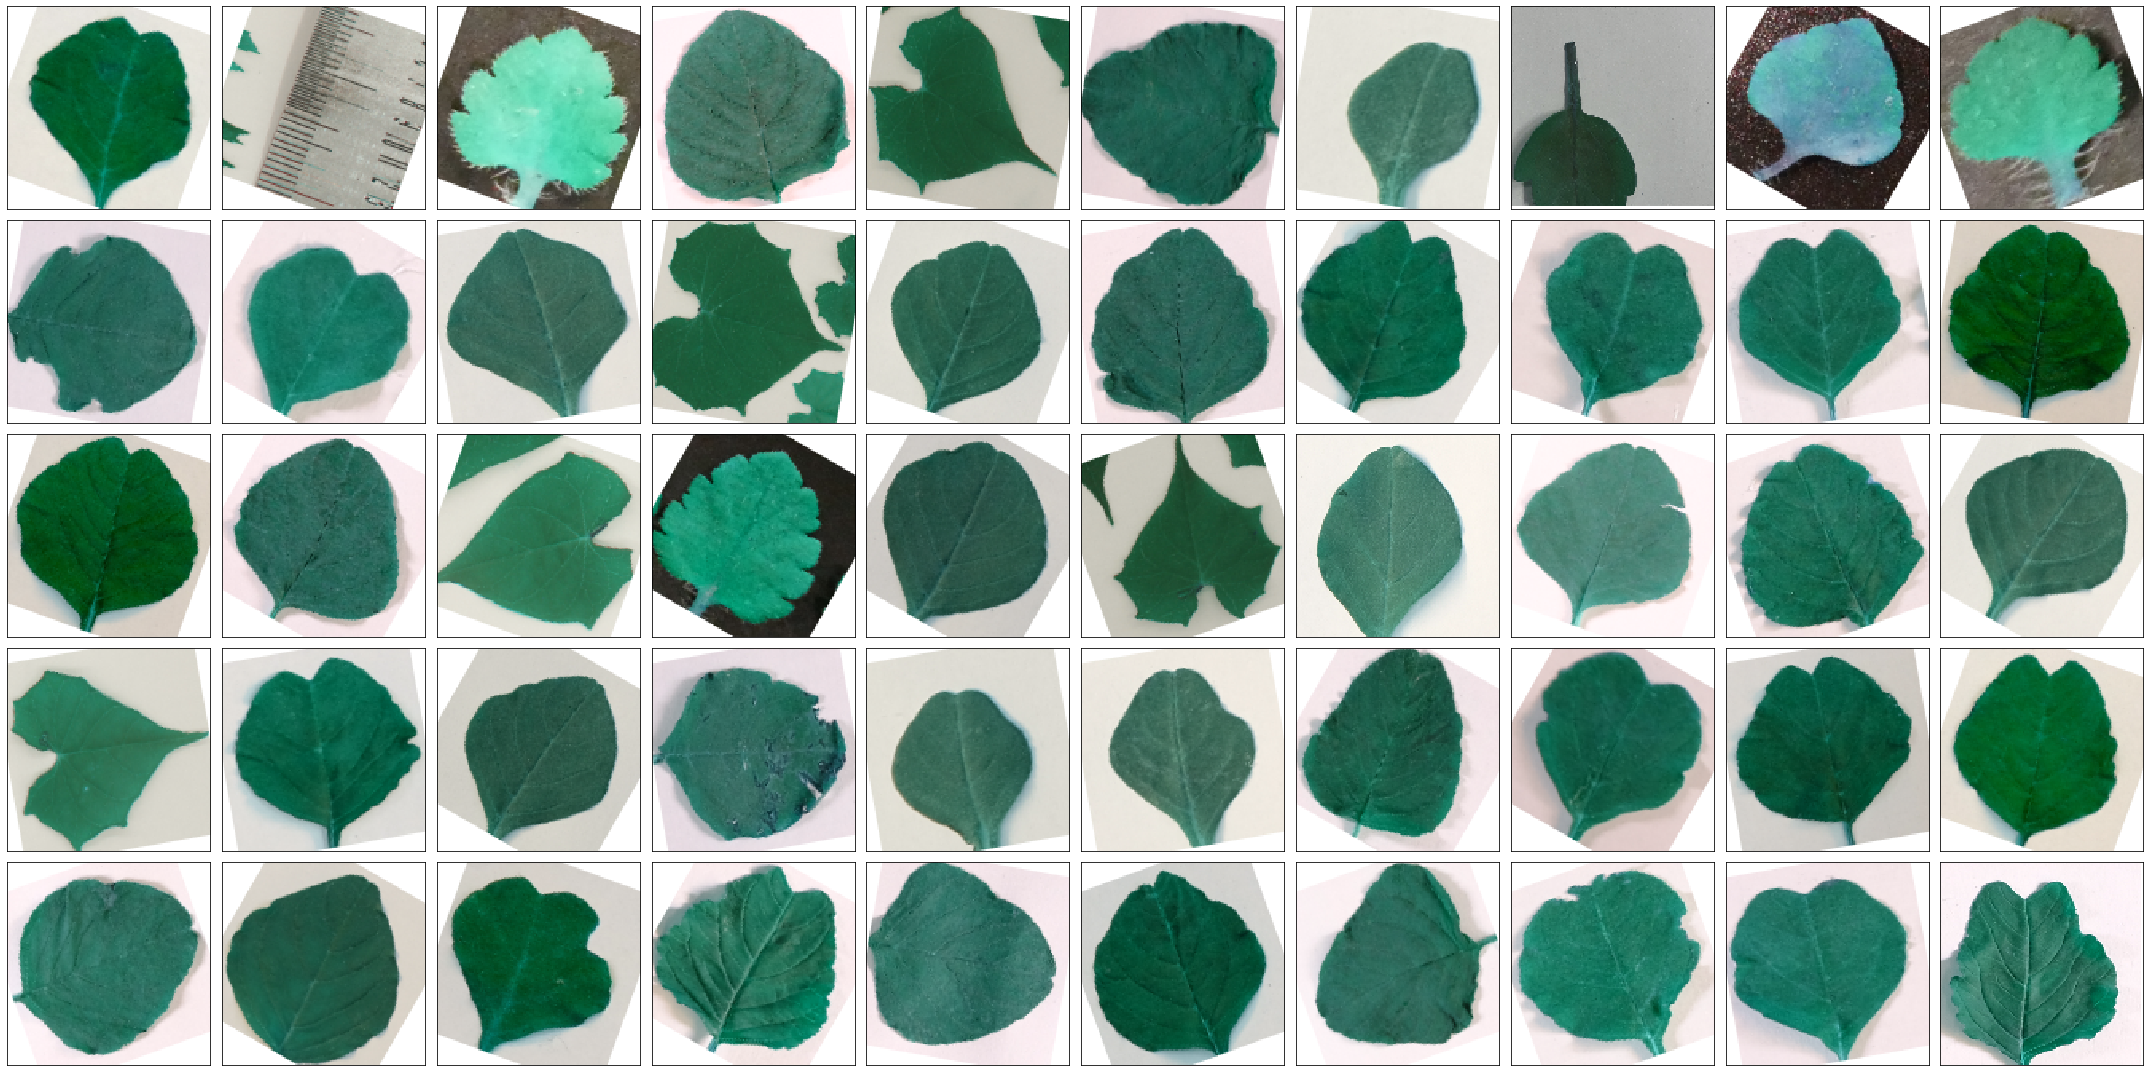

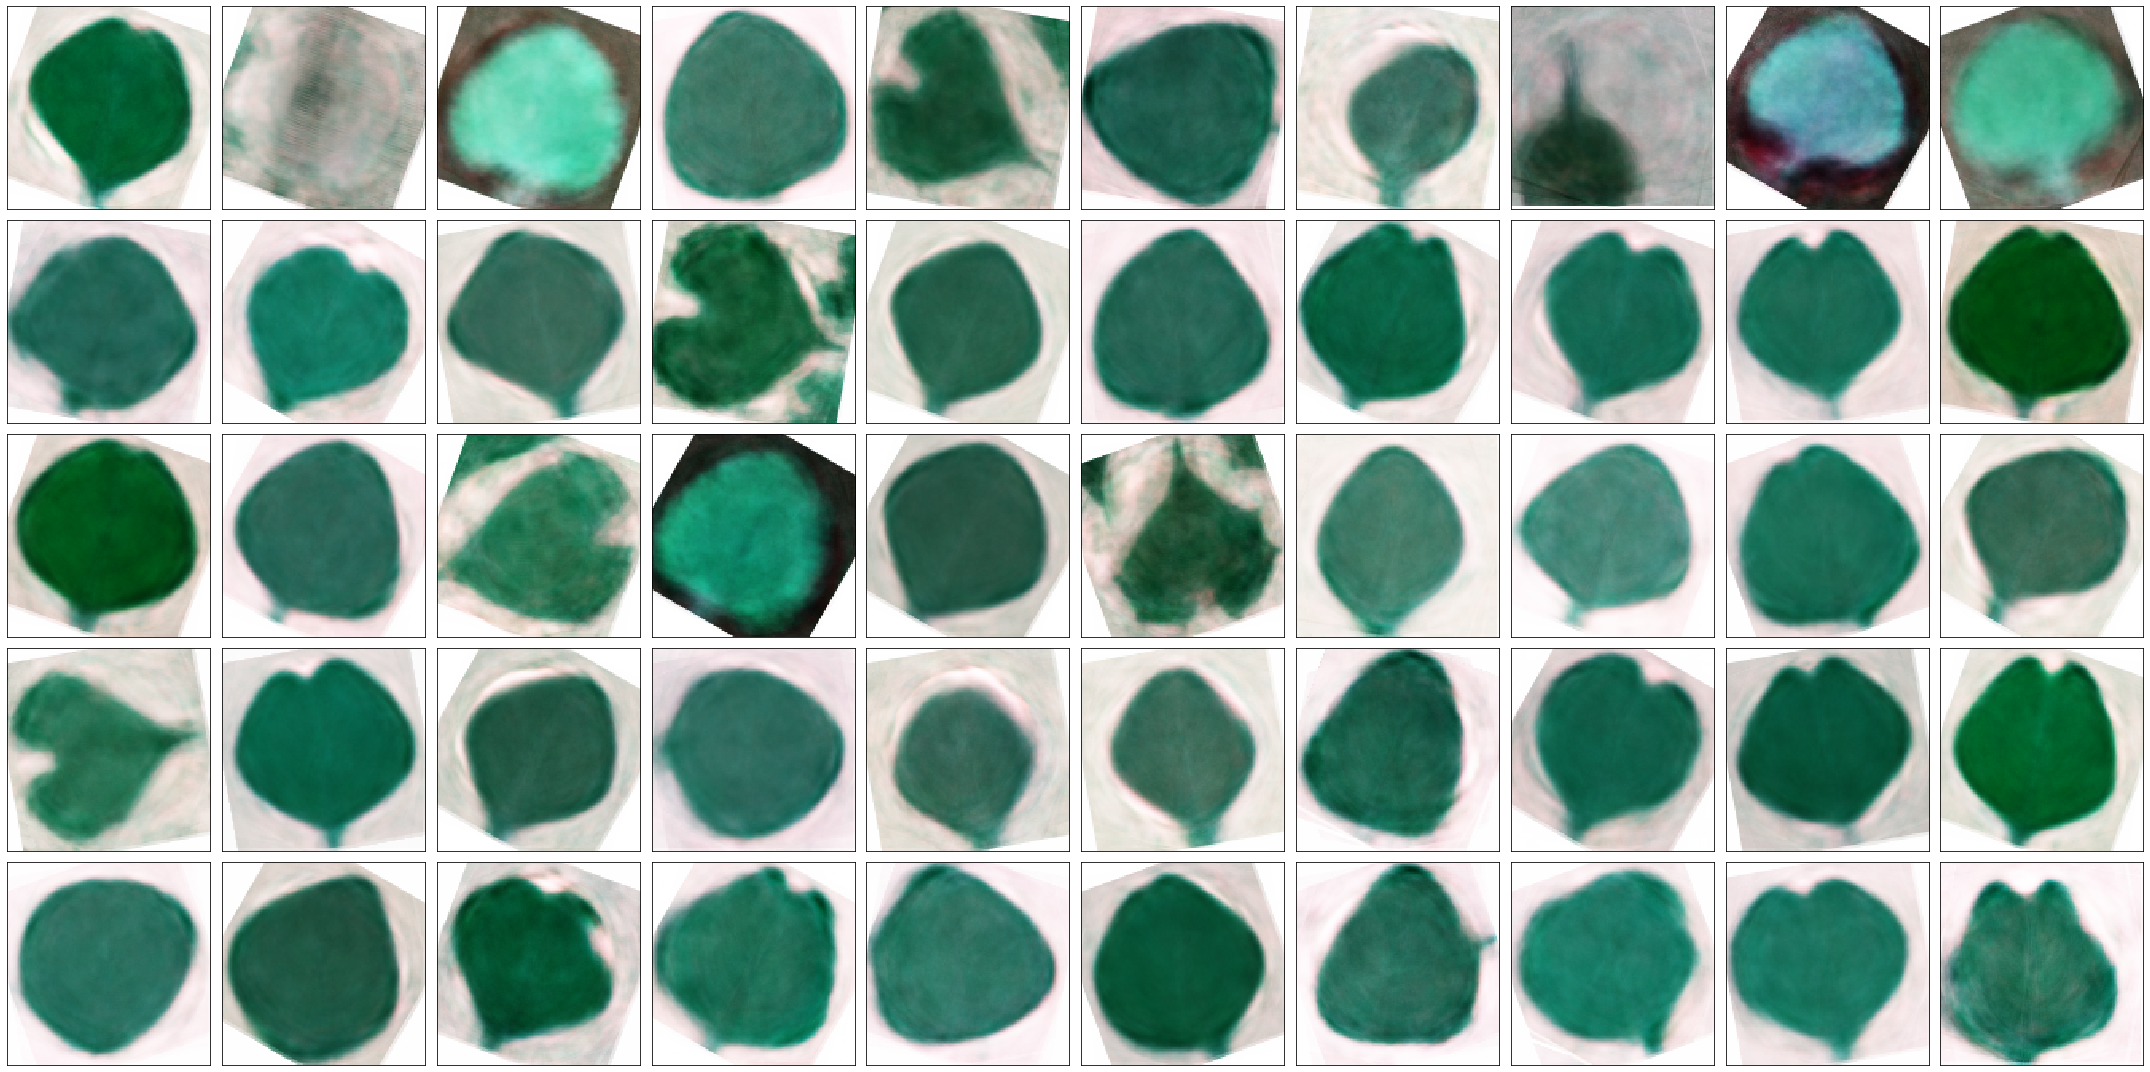

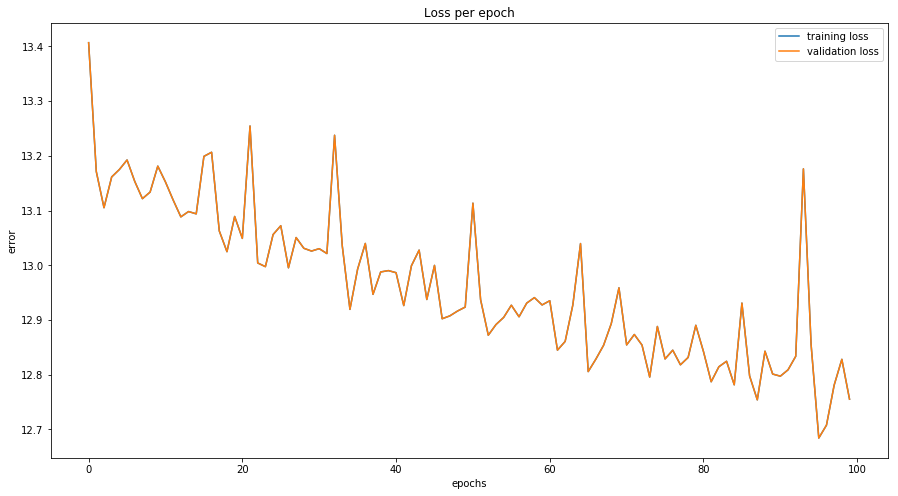

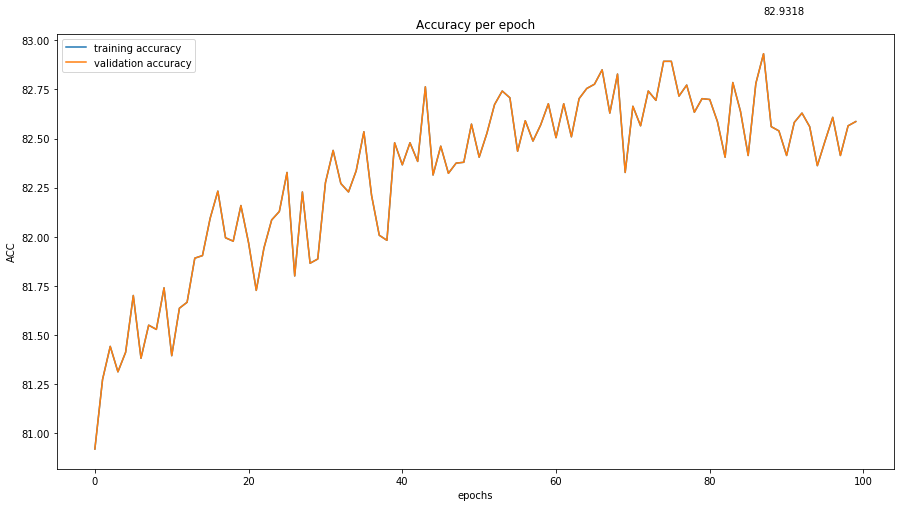

In [8]:
main()